### Build a (bad) MSM for T4L and create SynD model

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import deeptime
import pickle
import wedap
from tqdm.auto import tqdm

import MDAnalysis as mda

First, need dmat features from T4L simulation data.

In [10]:
def extract_dmat(tpr="sim1_dry.pdb", xtc="sim1-imaged.xtc"):
    # Step 1: Load the trajectory
    u = mda.Universe(tpr, xtc, in_memory=True, in_memory_step=1)
    
    # Select Cα atoms
    ca_atoms = u.select_atoms("name CA")
    n_residues = len(ca_atoms)
    
    # Step 2: Pre-allocate and fill the distance matrix array
    n_frames = int(len(u.trajectory)) / 10  # Number of frames in the trajectory
    distance_matrices = np.empty((n_frames, n_residues, n_residues), dtype=np.float32)
    
    # Calculate distances for each frame and fill the pre-allocated array
    for i, ts in tqdm(enumerate(u.trajectory[:n_frames]), total=n_frames):
        distances = np.linalg.norm(
            ca_atoms.positions[:, None, :] - ca_atoms.positions[None, :, :],
            axis=-1
        )
        distance_matrices[i] = distances  # Fill the pre-allocated array
    
    # Save the pre-cast distance matrix array
    #np.save("ca_distance_matrices.npy", distance_matrices)
    
    # Step 3: Preprocess the distance matrices for VAMP
    # Flatten upper triangle of distance matrices (excluding diagonal) to use as features
    triu_indices = np.triu_indices(n_residues, k=1)
    flattened_distances = np.array([
        distances[triu_indices]
        for distances in distance_matrices
    ])  # Shape: (n_frames, n_features)

    return flattened_distances

In [11]:
dist_feats = extract_dmat()
np.save("ca_dist_feats_flat_full.npy", dist_feats)

KeyboardInterrupt: 

Load feats directly instead of calculating

In [2]:
dist_feats = np.load("ca_dist_feats_flat.npy")

In [4]:
# Standardize data for dimensionality reduction
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#standardized_data = scaler.fit_transform(dist_feats)

PCA

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(dist_feats)

In [9]:
# Save the reduced data for plotting or further analysis
np.save("pca_reduced_data.npy", reduced_data)

Load pca projection features directly instead of calculating

In [ ]:
reduced_data = np.load("pca_reduced_data.npy")

TICA

In [ ]:
tica = deeptime.decomposition.TICA(lagtime=10, dim=2)
reduced_data = tica.fit_transform(dist_feats)

In [ ]:
# Save the reduced data for plotting or further analysis
np.save("tica_reduced_data.npy", reduced_data)

Load tica projection features directly instead of calculating

In [ ]:
reduced_data = np.load("tica_reduced_data.npy")

VAMP

In [ ]:
vamp = deeptime.decomposition.VAMP(lagtime=10, dim=2)
reduced_data = vamp.fit_transform(dist_feats)

In [ ]:
# Save the reduced data for plotting or further analysis
np.save("vamp_reduced_data.npy", reduced_data)

Load vamp projection features directly instead of calculating

In [ ]:
reduced_data = np.load("vamp_reduced_data.npy")

Plot reduced projections:

In [12]:
import mdap

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='RD0', ylabel='RD1'>)

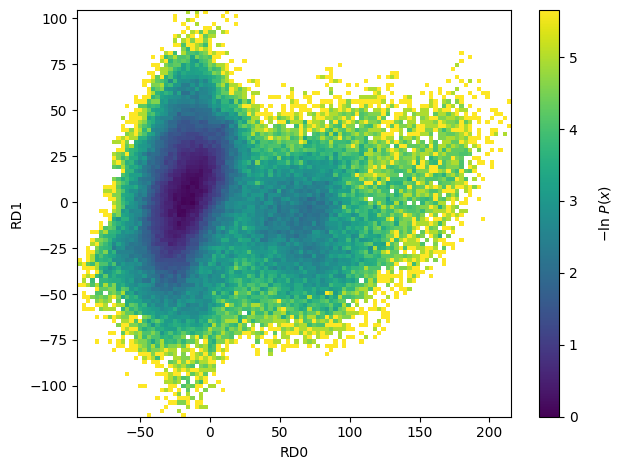

In [13]:
mdap.MD_Plot(Xname=reduced_data[:,0], xlabel="RD0", Xindex=0, Yname=reduced_data[:,1], ylabel="RD1", Yindex=0, data_type="pdist").plot()

Step 5: Build an MSM from VAMP-reduced data

In [ ]:
# Discretize the reduced data using clustering
from sklearn.cluster import KMeans
n_clusters = 100  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
discrete_data = kmeans.fit_predict(reduced_data)

Cluster using stratified kmeans instead

In [14]:
from sklearn.cluster import KMeans
from mr_toolkit.clustering import StratifiedClusters

In [15]:
# clusters per strata
n_clusters = 100
# bins in vamp0 space
bounds = [i for i in range(-50, 150, 25)]
len(bounds)

8

In [17]:
# clustering
clusterer = StratifiedClusters(n_clusters, bin_bounds=bounds)
clusterer.fit(reduced_data, coord_to_stratify=0)
discrete_data = clusterer.predict(reduced_data)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
discrete_data

array([463, 463, 463, ..., 723, 742, 703])

In [29]:
clusterer.cluster_centers

array([[-56.545074 , -26.596815 ],
       [-51.616108 ,  10.38545  ],
       [-65.18525  , -54.97037  ],
       ...,
       [132.76767  ,  28.601978 ],
       [140.1819   , -23.640106 ],
       [127.61704  ,  -6.4393377]], dtype=float32)

Build MSM

In [18]:
# Construct the MSM, using 1 step/ 10ps lagtime
msm = deeptime.markov.msm.MaximumLikelihoodMSM(lagtime=1)
msm_model = msm.fit(discrete_data).fetch_model()

In [30]:
# Save the MSM for future analysis
with open("msm_model.pkl", "wb") as f:
    pickle.dump([discrete_data, clusterer.cluster_centers, msm_model], f)

### Build SynD model from MSM

In [2]:
from synd.models.discrete.markov import MarkovGenerator
from synd.core import load_model

In [3]:
from scipy import sparse
from scipy.cluster.vq import vq

In [4]:
# Read previous data
with open(f'msm_model.pkl','rb') as file:
    [final_cluster, cluster_centers, final_msm] = pickle.load(file)

Load VAMP data

In [5]:
features = np.load("pca_reduced_data.npy")

#### Define backmapping coordinates (xyz coords)

In [6]:
# first grab frame for each cluster center
frames, _ = vq(cluster_centers, features)
print(f"frame index per cluster:\n {frames}")

frame index per cluster:
 [ 46094  10310  76035   9408  46572  10625  47558  76922  47324  46253
  78079  10594  47615  46045  10023  93081  76080  47206  83032  10643
  45779  76194  45745  10800  83039  45652  45927  46413  92530  46082
  10609  10274  75954   9462  45451   9233  10751  45610   9420  51861
  76502  48134  46361  10601  10383  47332  46673  11959  77142  48106
  46558  45548   9268  51058  45370  78045  45623  76116  48178  45770
   9344  45696  10104  47383  46845   9225  46176  77156  77150  46670
  10092  47485  10402  45627  47306  45756  46128  45553  47277  10168
   3762  45973  47544  45824  76165  47356  47668   8160  84139  10236
   9342  77696  45961  47657  92563  47895   9473  46366  45369  47329
  51992  45231  11846  75943  50989  12486   5609   5467  37785  78795
  47911  45374  18156  10055  42982  76085  64831  41248   8895  69290
  82234   8586  26299  10779  52573  51083  10738  82974  10603  32236
  78005  17024  96930  21747   6572  75923   8351  

I need to create a dict that maps each cluster to the coord space, e.g.
``` Python
{0: array([0.19300674, ...]),
 1: array([0.14842148, ...]),
 2: array([0.12663524, ...]),
 3: array([0.16085377, ...]),
 ...
 ```
Where the array = xyz coordinates of all T4L atoms

Load in the trajectory

In [7]:
u = mda.Universe("sim1_dry.pdb", "sim1-imaged.xtc", in_memory=True, in_memory_step=1)

In [8]:
u.trajectory.n_frames

1066178

In [9]:
def extract_frame_coords(u, frame):
    # Select the frame you want
    u.trajectory[frame]
    
    # Select the desired atoms (e.g., all atoms, backbone, or custom selection)
    atom_group = u.select_atoms("all")
    
    # Extract the coordinates for the selected atoms
    coordinates = atom_group.positions  # Numpy array of shape (n_atoms, 3)
    
    return coordinates

In [10]:
# The keys of the dict are just the cluster index
c_index = [i for i in range(frames.shape[0])]

In [11]:
# and then store the coordiantes as the backmapper
n_frames = u.trajectory.n_frames
n_atoms = u.atoms.n_atoms

# Pre-allocate the array for storing all coordinates
coordinates = np.zeros((n_frames, n_atoms, 3))
for i, f in enumerate(frames):
    coordinates[i] = extract_frame_coords(u, f)

In [12]:
coordinates[0]

array([[45.93000412, 50.20000458, 18.94000053],
       [44.99000168, 50.43000031, 19.22000122],
       [45.87000275, 50.09000397, 17.94000053],
       ...,
       [50.06000137, 56.10000229, 11.18000031],
       [51.04999924, 56.83000183, 11.38000011],
       [49.95000458, 55.38000107, 10.11000061]])

In [13]:
# okay, now make it into a dict
backmapper = dict(zip(c_index, coordinates))

In [14]:
backmapper

{0: array([[45.93000412, 50.20000458, 18.94000053],
        [44.99000168, 50.43000031, 19.22000122],
        [45.87000275, 50.09000397, 17.94000053],
        ...,
        [50.06000137, 56.10000229, 11.18000031],
        [51.04999924, 56.83000183, 11.38000011],
        [49.95000458, 55.38000107, 10.11000061]]),
 1: array([[74.59000397, 46.18000031, 24.85000229],
        [74.70000458, 45.38999939, 24.23999977],
        [75.44000244, 46.73000336, 24.78000259],
        ...,
        [73.97000122, 55.94000244, 16.01000023],
        [73.33000183, 56.02000427, 14.94000053],
        [74.66000366, 56.86000443, 16.46000099]]),
 2: array([[52.45000458, 53.92000198, 14.25000095],
        [53.25000381, 53.40000153, 13.90999985],
        [51.53000259, 53.50000381, 14.28000069],
        ...,
        [53.11000443, 63.19000244, 11.69000053],
        [54.24000168, 63.73000336, 11.81000137],
        [52.88000107, 62.55000305, 10.62000084]]),
 3: array([[70.76000214, 43.47999954, 28.62000275],
        [70.

In [15]:
backmapper[0].shape

(2612, 3)

In [18]:
# save backmapper
with open("backmapper.pkl", "wb") as f:
    pickle.dump(backmapper, f)

In [6]:
# open backmapper
with open(f'backmapper.pkl','rb') as file:
    backmapper = pickle.load(file)

#### Now create and save SynD model

In [7]:
synd_model = MarkovGenerator(
    transition_matrix=final_msm.transition_matrix,
    backmapper=backmapper.get,
    seed=None,
)

In [8]:
synd_model.save('t4l.synd')

Run SynD from arbitrary initial state

In [9]:
%%time

# each step = 1ps
trajectory = synd_model.generate_trajectory(
    initial_states=np.array([0]),
    n_steps=200,
)
trajectory

CPU times: user 4.72 ms, sys: 3.99 ms, total: 8.71 ms
Wall time: 5.53 ms


array([[  0,   0,  21,  78,   0,  71,  29, 174, 110, 129, 150, 176, 108,
        297, 140, 193, 249, 116, 100, 146, 165, 100, 125, 116, 297, 249,
        274, 291, 270, 145, 119, 121, 116, 146, 253, 272, 275, 232, 253,
        291, 291, 116, 213, 282, 280, 238, 231, 211, 280, 253, 117, 210,
        232, 205, 358, 355, 397, 341, 285, 238, 362, 310, 308, 393, 345,
        384, 227, 299, 217, 246, 270, 246, 269, 214, 325, 239, 367, 367,
        201, 214, 239, 275, 232, 213, 116, 297, 282, 280, 238, 231, 387,
        355, 280, 282, 312, 275, 360, 392, 303, 392, 334, 232, 342, 355,
        312, 280, 238, 355, 347, 396, 280, 215, 231, 288, 200, 236, 236,
        140, 259, 143, 220, 233, 161, 200, 288, 248, 245, 161, 247, 290,
        290, 220, 253, 140, 259, 125, 259, 271, 233, 207, 175, 122, 197,
        147, 132, 147, 259, 259, 233, 168, 149, 149, 197, 166, 148, 127,
        148, 148, 122, 207, 222, 242, 188, 133, 143, 290, 219, 272, 358,
        381, 320, 314, 381, 387, 380, 334, 392, 380

In [10]:
trajectory.shape

(1, 200)

In [11]:
mapped_traj = synd_model.backmap(trajectory)

In [12]:
mapped_traj.shape

(1, 200, 2612, 3)

In [13]:
mapped_traj

array([[[[45.93000412, 50.20000458, 18.94000053],
         [44.99000168, 50.43000031, 19.22000122],
         [45.87000275, 50.09000397, 17.94000053],
         ...,
         [50.06000137, 56.10000229, 11.18000031],
         [51.04999924, 56.83000183, 11.38000011],
         [49.95000458, 55.38000107, 10.11000061]],

        [[45.93000412, 50.20000458, 18.94000053],
         [44.99000168, 50.43000031, 19.22000122],
         [45.87000275, 50.09000397, 17.94000053],
         ...,
         [50.06000137, 56.10000229, 11.18000031],
         [51.04999924, 56.83000183, 11.38000011],
         [49.95000458, 55.38000107, 10.11000061]],

        [[51.24000168, 52.45000458, 15.35000038],
         [50.81000519, 53.02000046, 14.6400013 ],
         [51.88999939, 51.79000473, 14.94000053],
         ...,
         [51.41000366, 64.15000153, 11.69000053],
         [51.44000244, 65.22000122, 12.34000111],
         [51.62000275, 64.1000061 , 10.47000027]],

        ...,

        [[45.6000061 , 53.7100029 , 22

#### Now convert back to MDAnalysis universe and do analysis

In [14]:
syn_u = mda.Universe("sim1_dry.pdb")

In [16]:
syn_u.load_new(mapped_traj[0], format="memory")

<Universe with 2612 atoms>

In [17]:
syn_u.trajectory

<MemoryReader with 200 frames of 2612 atoms>

Example RoG calc

In [21]:
# Vectorized calculation of radius of gyration for the whole trajectory
rog = np.array([syn_u.atoms.radius_of_gyration() for ts in syn_u.trajectory])

In [22]:
rog.shape

(200,)

In [23]:
rog

array([16.46043051, 16.46043051, 16.43682518, 16.47218214, 16.46043051,
       16.41826561, 16.51091976, 16.53738998, 16.59469019, 16.50563991,
       16.50990415, 16.54850539, 16.59166318, 16.66639789, 16.63884015,
       16.58858427, 16.57167043, 16.5880248 , 16.6294804 , 16.56958127,
       16.53847327, 16.6294804 , 16.70858996, 16.5880248 , 16.66639789,
       16.57167043, 16.64675692, 16.69584033, 16.63652527, 16.59978555,
       16.56556403, 16.55683498, 16.5880248 , 16.56958127, 16.67757408,
       16.6768734 , 16.66800865, 16.64226416, 16.67757408, 16.69584033,
       16.69584033, 16.5880248 , 16.71783901, 16.63752161, 16.6647525 ,
       16.70272744, 16.60804931, 16.67121175, 16.6647525 , 16.67757408,
       16.62937617, 16.49840781, 16.64226416, 16.69344119, 16.72859693,
       16.70381029, 16.78104242, 16.71116952, 16.7264104 , 16.70272744,
       16.72393782, 16.69226467, 16.79023482, 16.85884434, 16.76558558,
       16.73793984, 16.73746638, 16.6984709 , 16.63423547, 16.68

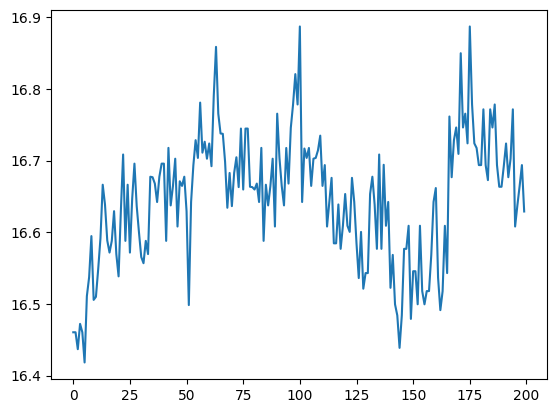

In [24]:
plt.plot(rog)

#### Finally, save synthetic traj out to an xtc file:

In [25]:
from MDAnalysis.coordinates.XTC import XTCWriter

In [36]:
# Define the output file name
output_xtc = "synd_test.xtc"

# Create an XTCWriter object
with XTCWriter(output_xtc, n_atoms=syn_u.atoms.n_atoms) as writer:
    for ts in syn_u.trajectory:
        writer.write(syn_u.atoms) 

Test load back in:

In [37]:
u = mda.Universe("sim1_dry.pdb", output_xtc)

In [38]:
u.trajectory

<XTCReader synd_test.xtc with 200 frames of 2612 atoms>

In [39]:
rog = np.array([u.atoms.radius_of_gyration() for ts in u.trajectory])

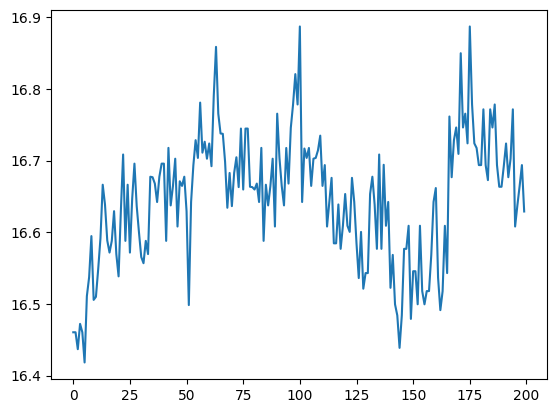

In [40]:
plt.plot(rog)